0.25


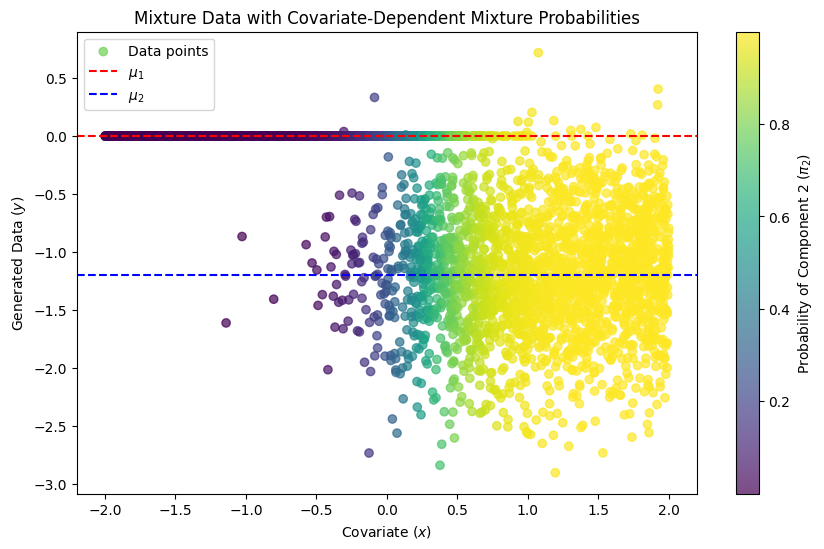

In [1]:
import numpy as np
import matplotlib.pyplot as plt
 
n_samples = 5000
a, b = 5.0, -1.0  # Coefficients for logistic regression to control mixture probabilities
mu_1, sigma_1_sq = 0.0, 0.2
mu_2, sigma_2_sq = -1.20,  0.5


print(sigma_2_sq   **2 )

sebetahat= np.random.uniform( 0.1, 0.5, n_samples)
# Covariates
x = np.random.uniform(-2, 2, n_samples)

# Mixture probabilities
pi_2 = 1 / (1 + np.exp(-(a * x + b)))  # Sigmoid function for covariate-dependent pi_2
pi_1 = 1 - pi_2  # Ensure pi_1 + pi_2 = 1

# Generate data
y = np.zeros(n_samples)
betahat = np.zeros(n_samples)
c = np.zeros(n_samples, dtype=int)  # Ensure c is an integer array
for i in range(n_samples):
    # Use .item() to extract the scalar from np.random.choice
    c[i] = np.random.choice([0, 1], p=[pi_1[i], pi_2[i]])
    if c[i] == 0:
        y[i] = 0
        betahat[i]= y[i]+ np.random.normal(0, sebetahat[i] )
    else:
        y[i] = np.random.normal(mu_2,  sigma_2_sq   )
        betahat[i]= y[i]+ np.random.normal(0,   sebetahat[i] )


# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=pi_2, cmap='viridis', label='Data points', alpha=0.7)
plt.colorbar(label='Probability of Component 2 ($\pi_2$)')
plt.axhline(mu_1, color='red', linestyle='--', label='$\mu_1$')
plt.axhline(mu_2, color='blue', linestyle='--', label='$\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel('Generated Data ($y$)')
plt.title('Mixture Data with Covariate-Dependent Mixture Probabilities')
plt.legend()
plt.show()


In [2]:
np.var(y)

np.float64(0.46977045099551024)

In [3]:
np.var(betahat)

np.float64(0.5692389564750551)

In [4]:
0.2**2+0.5**2

0.29000000000000004

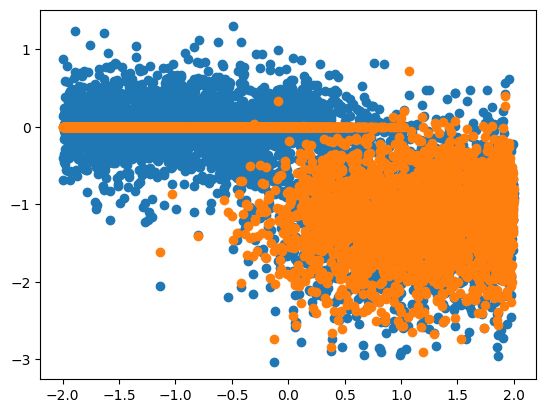

In [5]:

plt.scatter(x,betahat)
 
plt.scatter(x,y)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the MDN model
class MDN(nn.Module):
    def __init__(self, input_dim):
        super(MDN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # Output: logit for pi_2
        )
        self.mu_1 = 0.0  # Fixed mean for component 1
        self.sigma_1_sq = 0.0  # Fixed variance for component 1
        self.mu_2 = nn.Parameter(torch.tensor(0.0))  # Learnable mean for component 2

    def forward(self, x):
        logit_pi2 = self.fc(x).squeeze()
        pi_2 = torch.sigmoid(logit_pi2)
        pi_1 = 1 - pi_2
        return pi_1, pi_2, self.mu_2


# Loss function: Negative Log Likelihood
def mdn_loss(pi_1, pi_2, mu_2, sigma_2_sq, targets, sd_noise):
    mu_1 = torch.tensor(0.0)
    sigma_1_sq_total = sd_noise**2
    sigma_2_sq_total = sigma_2_sq + sd_noise**2

    p1 = (1 / torch.sqrt(2 * torch.pi * sigma_1_sq_total)) * torch.exp(-0.5 * ((targets - mu_1) ** 2) / sigma_1_sq_total)
    p2 = (1 / torch.sqrt(2 * torch.pi * sigma_2_sq_total)) * torch.exp(-0.5 * ((targets - mu_2) ** 2) / sigma_2_sq_total)

    mixture_pdf = pi_1 * p1 + pi_2 * p2
    return -torch.mean(torch.log(mixture_pdf + 1e-8))


# Compute responsibilities (gamma values) for component 2
def compute_responsibilities(pi_1, pi_2,   mu_2, sigma_2_sq, targets, sd_noise):
    sigma_1_sq_total =0 + sd_noise**2
    sigma_2_sq_total = sigma_2_sq + sd_noise**2

    p1 = (1 / torch.sqrt(2 * torch.pi * sigma_1_sq_total)) * torch.exp(-0.5 * ((targets ) ** 2) / sigma_1_sq_total)
    p2 = (1 / torch.sqrt(2 * torch.pi * sigma_2_sq_total)) * torch.exp(-0.5 * ((targets - mu_2) ** 2) / sigma_2_sq_total)

    return (pi_2 * p2) / (pi_1 * p1 + pi_2 * p2)
  
# Perform the M-step to update sigma_2^2
def m_step_sigma2(gamma_2, mu_2, targets, sd_noise):
    residuals_sq = (targets - mu_2) ** 2
    sigma_0_sq = sd_noise**2
    numerator = torch.sum(( gamma_2 )* (residuals_sq - sigma_0_sq))
    denominator = torch.sum(( gamma_2 ))
    return torch.clamp(numerator / denominator, min=1e-6)


# Generate training data
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(betahat, dtype=torch.float32)
obs_sd_noise = torch.tensor(sebetahat, dtype=torch.float32)

# Initialize model and optimizer
model = MDN(input_dim=1)
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.01)

# Training loop
n_epochs = 1000
sigma_2_sqe = torch.tensor(1, requires_grad=False)

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    pi_1, pi_2, mu_2e = model(x_tensor)

    gamma_2 = compute_responsibilities(
        pi_1=pi_1, pi_2=pi_2,
       
        mu_2=mu_2e, 
        sigma_2_sq=sigma_2_sqe,
        targets=y_tensor,
        sd_noise=obs_sd_noise
    ) 
    with torch.no_grad():
        sigma_2_sqe = m_step_sigma2( gamma_2, mu_2e, y_tensor, obs_sd_noise)

    loss = mdn_loss(pi_1, pi_2, mu_2e, sigma_2_sqe, y_tensor, obs_sd_noise)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, Sigma_2^2: {sigma_2_sqe.item()}")

# Evaluation



Epoch 0, Loss: 1.2200995683670044, Sigma_2^2: 1.3233633041381836
Epoch 100, Loss: 0.6024662852287292, Sigma_2^2: 0.3342463970184326
Epoch 200, Loss: 0.5798412561416626, Sigma_2^2: 0.26314079761505127
Epoch 300, Loss: 0.5796874165534973, Sigma_2^2: 0.26035282015800476
Epoch 400, Loss: 0.579576849937439, Sigma_2^2: 0.2573679983615875
Epoch 500, Loss: 0.5794644355773926, Sigma_2^2: 0.25415146350860596
Epoch 600, Loss: 0.5793910026550293, Sigma_2^2: 0.2539532780647278
Epoch 700, Loss: 0.5793130993843079, Sigma_2^2: 0.2538224458694458
Epoch 800, Loss: 0.5792431831359863, Sigma_2^2: 0.25357502698898315
Epoch 900, Loss: 0.5791818499565125, Sigma_2^2: 0.25344276428222656


In [7]:
model.eval()
with torch.no_grad():
    pi_1, pi_2, mu_2e = model(x_tensor)

pi_np = pi_2.detach().numpy()
mu_2e= mu_2e.detach().numpy()
sigma_prior = np.sqrt(sigma_2_sqe.detach().numpy())


post_mean = np.zeros_like(betahat)
post_var = np.zeros_like(betahat)
import os
import sys
import matplotlib.pyplot as plt
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from posterior_computation import *

for i in range(len(betahat)):
        post_mean[i], post_var[i] = posterior_point_mass_normal(
            betahat=betahat[i],
            sebetahat=sebetahat[i],
            pi=( 1-pi_np[i]),  # Scalar pi for each observation
            mu0=0,  # Fixed mean for the point mass
            mu1=mu_2e,  # Global parameter
            sigma_0=sigma_prior  # Global parameter
            )
post_mean2= post_var+ post_mean**2 

In [8]:
posterior_point_mass_normal(
            betahat=betahat[i],
            sebetahat=sebetahat[i],
            pi=( pi_np[i]),  # Scalar pi for each observation
            mu0=0,  # Fixed mean for the point mass
            mu1=mu_2e,  # Global parameter
            sigma_0=sigma_prior  # Global parameter
            )

(np.float64(-1.7198879999235082), np.float64(0.08234024343366676))

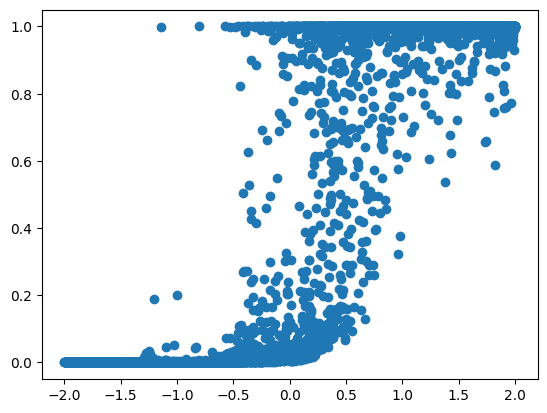

In [9]:
plt.scatter(x,gamma_2.detach().numpy() )

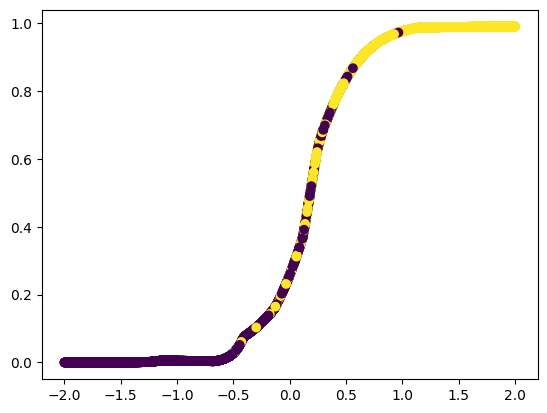

In [10]:
plt.scatter(x,pi_2.detach().numpy(), c=c )

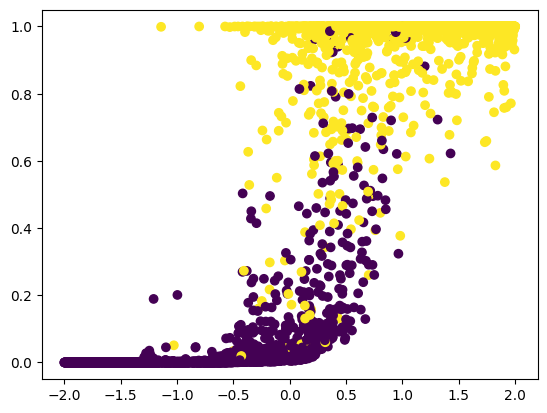

In [11]:
plt.scatter(x,gamma_2.detach().numpy(), c=c )

In [12]:
gamma_2.detach().numpy() 

array([0.99999934, 0.00190193, 0.2093894 , ..., 0.9999998 , 0.06618888,
       1.        ], shape=(5000,), dtype=float32)

In [13]:
tt= (betahat-mu_2)**2

print(sum(( gamma_2.detach().numpy()* (tt))))
print(sum(gamma_2.detach().numpy()* (sebetahat**2)))
sum(gamma_2.detach().numpy())

808.6863855848461
230.3717572767036


np.float32(2281.023)

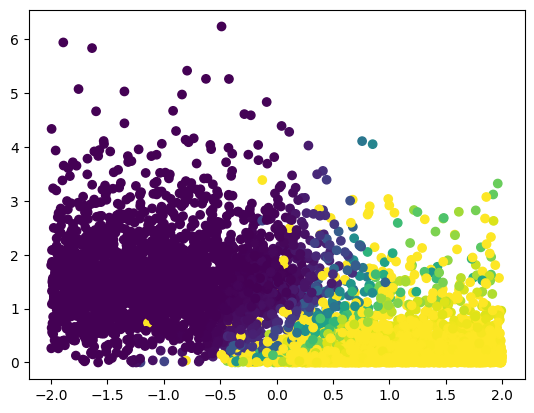

In [14]:
plt.scatter(x,tt,c=gamma_2.detach().numpy() )


In [15]:
sigma_2_sq**2

0.25

In [16]:
sigma_2_sqe.detach().numpy()

array(0.25347215, dtype=float32)

<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

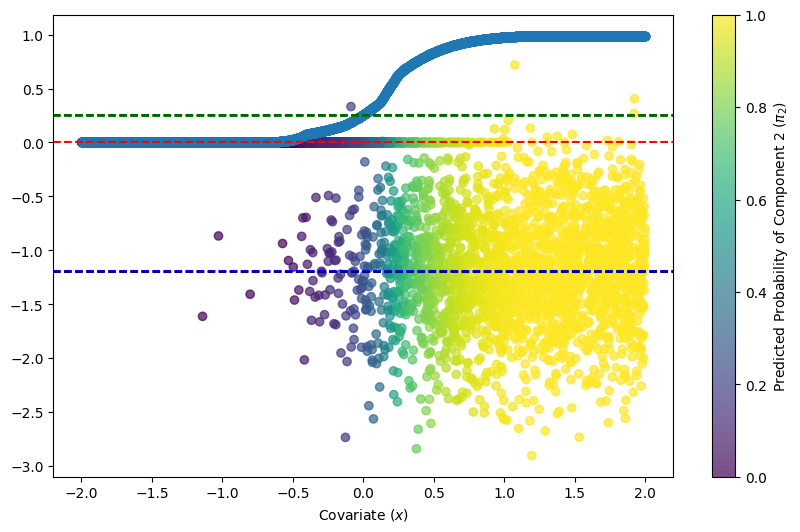

In [17]:
# Visualize predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=pi_2.numpy(), cmap='viridis', alpha=0.7, label='Data points')
plt.scatter(x, pi_2,  alpha=0.7 )
plt.colorbar(label='Predicted Probability of Component 2 ($\pi_2$)')
plt.axhline(0.0, color='red', linestyle='--', label='Fixed $\mu_1$')
plt.axhline(mu_2e , color='blue', linestyle='--', label='Predicted $\mu_2$')

plt.axhline(mu_2, color='darkblue', linestyle='--', label='Predicted $\mu_2$')
plt.axhline(sigma_2_sq   **2 , color='green', linestyle='--', label='Predicted $\mu_2$')

plt.axhline( sigma_2_sqe.detach().numpy(), color='darkgreen', linestyle='--', label='Predicted $\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel


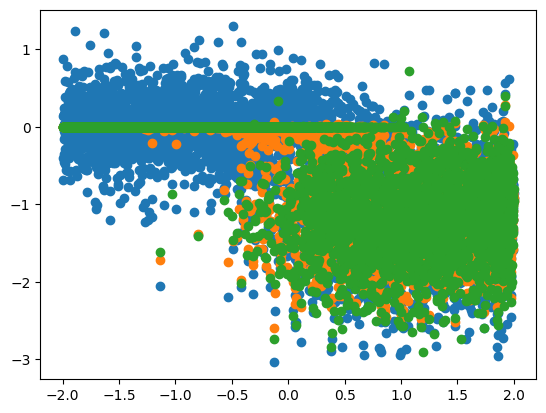

In [18]:
plt.scatter(x,betahat
            )
plt.scatter(x, post_mean)
plt.scatter(x, y)

(array([2539.,   78.,   46.,   29.,   32.,   28.,   42.,   42.,   80.,
        2084.]),
 array([1.84618418e-08, 1.00000016e-01, 2.00000018e-01, 3.00000042e-01,
        4.00000036e-01, 5.00000000e-01, 6.00000024e-01, 6.99999988e-01,
        8.00000012e-01, 9.00000036e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

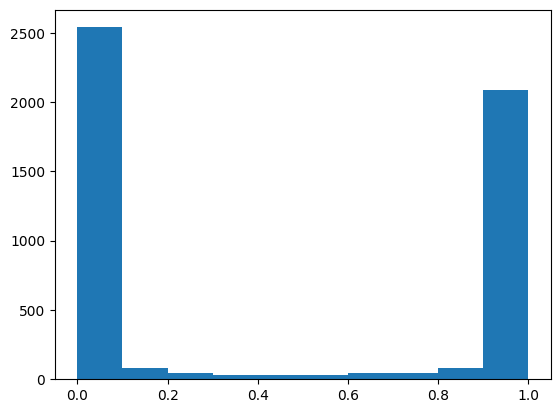

In [19]:
plt.hist(gamma_2.detach().numpy() )

In [20]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from empirical_mdn import *
from covaraite_moderated_generalized_binary import *

In [ ]:
res = cgb_posterior_means(x, betahat, sebetahat, n_epochs=100, batch_size=50)

tensor(3792.8237)
tensor(2902.5686)
tensor(3319.5498)
tensor(2466.7134)
tensor(2893.1772)
tensor(2541.6980)
tensor(2486.9673)
tensor(2585.6106)
tensor(2092.9800)
tensor(2440.8772)
tensor(1794.3574)
tensor(2531.7373)
tensor(1531.4502)
tensor(2557.1477)
tensor(1297.0535)
tensor(2506.7371)
tensor(1119.2679)
tensor(2471.5771)
tensor(987.0395)
tensor(2461.2996)
tensor(894.5818)
tensor(2452.5671)
tensor(791.5036)
tensor(2393.1052)
tensor(742.3237)
tensor(2385.8362)
tensor(702.6252)
tensor(2365.0591)
tensor(668.6207)
tensor(2345.9912)
tensor(641.3724)
tensor(2324.1506)
tensor(677.7825)
tensor(2364.6367)
tensor(618.8383)
tensor(2303.3574)
tensor(633.6192)
tensor(2318.4927)
tensor(604.3030)
tensor(2295.9368)
tensor(622.1310)
tensor(2318.7773)
tensor(610.8521)
tensor(2310.5750)
tensor(598.4460)
tensor(2290.8042)
tensor(613.1433)
tensor(2311.5940)
tensor(606.6163)
tensor(2298.8315)
tensor(618.1174)
tensor(2309.4832)
tensor(621.9552)
tensor(2312.0032)
tensor(599.8838)
tensor(2297.3628)
tensor(583.

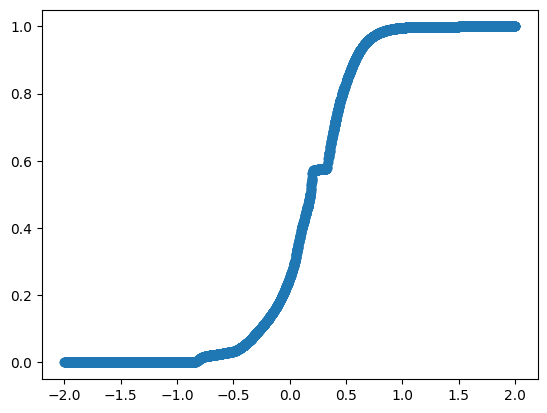

In [73]:
plt.scatter(x, res.pi)

<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

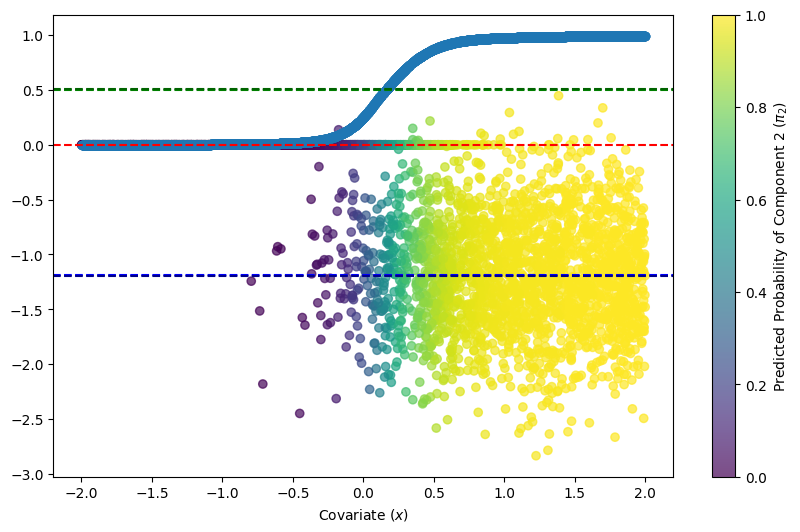

In [ ]:
# Visualize predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c= res.pi.numpy(), cmap='viridis', alpha=0.7, label='Data points')
plt.scatter(x,  res.pi,  alpha=0.7 )
plt.colorbar(label='Predicted Probability of Component 2 ($\pi_2$)')
plt.axhline(0.0, color='red', linestyle='--', label='Fixed $\mu_1$')
plt.axhline(res.mu_1 , color='blue', linestyle='--', label='Predicted $\mu_2$')

plt.axhline(mu_2, color='darkblue', linestyle='--', label='Predicted $\mu_2$')
plt.axhline(sigma_2_sq    , color='green', linestyle='--', label='Predicted $\mu_2$')

plt.axhline(  res.sigma_0 , color='darkgreen', linestyle='--', label='Predicted $\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel


In [70]:
res.mu_1

array(-0.0986, dtype=float32)

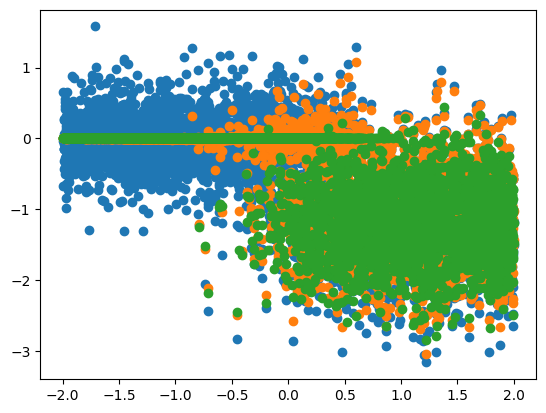

In [71]:
plt.scatter(x,betahat
            )
plt.scatter(x, res.post_mean)
plt.scatter(x, y)

In [59]:

X=x
batch_size=128
hidden_dim=65
n_layers=4
lr=0.001
if X.ndim == 1:
        X = X.reshape(-1, 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dataset = DensityRegressionDataset(X_scaled, betahat, sebetahat)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

input_dim = X_scaled.shape[1]
model = cov_GB(input_dim, hidden_dim, n_layers)
optimizer = optim.Adam(model.parameters(), lr=lr)

    

In [60]:
sigma_2_sqe = torch.tensor(.50, requires_grad=False)

for epoch in range(1):
        model.train()
        running_loss = 0.0
        full_dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
        with torch.no_grad():
            for inputs, targets, noise_std in full_dataloader:
                pi_1, pi_2, mu_2e = model(inputs)
                gamma_2 = compute_responsibilities(
                pi_1=pi_1, pi_2=pi_2, mu_2=mu_2e,
                sigma_2_sq=sigma_2_sqe,
                targets=targets,  # Use scaled targets
                sd_noise=noise_std  # Use scaled noise_std
                )
            sigma_2_sqe = m_step_sigma2(gamma_2, mu_2e, targets, noise_std)
            print(sigma_2_sqe)
        for inputs, targets, noise_std in dataloader:
            optimizer.zero_grad()
            pi_1, pi_2, mu_2e = model(inputs)

             

            loss = two_component_mdn_loss(pi_1, pi_2, mu_2e, sigma_2_sqe, targets, noise_std)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        #print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(dataloader):.4f}")


tensor(3834.5845)
tensor(2943.1792)
tensor(1.3029)


In [61]:
for inputs, targets, noise_std in full_dataloader:
                pi_1, pi_2, mu_2e = model(inputs)
                gamma_2 = compute_responsibilities(
                pi_1=pi_1, pi_2=pi_2, mu_2=mu_2e,
                sigma_2_sq=sigma_2_sqe,
                targets=targets,  # Use scaled targets
                sd_noise=noise_std  # Use scaled noise_std
                )
              
        

In [62]:
sigma_2_sqe = m_step_sigma2(gamma_2, mu_2e, targets, noise_std)
 

tensor(3627.3853, grad_fn=<SumBackward0>)
tensor(2386.4670, grad_fn=<SumBackward0>)


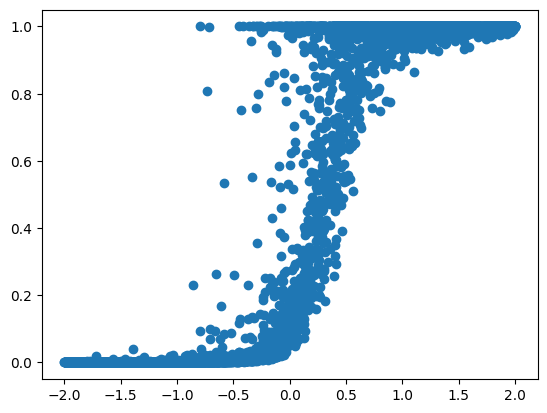

In [ ]:
plt.scatter(x, gamma_2.detach().numpy())

In [64]:
residuals_sq = (targets - mu_2) ** 2
sigma_0_sq = noise_std**2
numerator = torch.sum(gamma_2 * (residuals_sq - sigma_0_sq))
denominator = torch.sum(gamma_2)

In [65]:
numerator /denominator 

tensor(0.3305, grad_fn=<DivBackward0>)

In [66]:

    model.eval()
    with torch.no_grad():
        full_dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
        for inputs, targets, noise_std in full_dataloader:
            pi_1, pi_2, mu_2e = model(inputs)

    


        
    pi_np = pi_2.detach().numpy()
    mu_2e = mu_2e.detach().numpy()
    sigma_prior = np.sqrt(sigma_2_sqe.detach().numpy())

    post_mean = np.zeros_like(betahat)
    post_var = np.zeros_like(betahat)

    for i in range(len(betahat)):
        post_mean[i], post_var[i] = posterior_point_mass_normal(
            betahat=betahat[i],
            sebetahat=sebetahat[i],
            pi=(1 - pi_np[i]),  # Scalar pi for each observation
            mu0=0,  # Fixed mean for the point mass
            mu1=mu_2e,  # Global parameter
            sigma_0=sigma_prior  # Global parameter
        )
    post_mean2 = post_var + post_mean**2
    model_param = model.state_dict()

    return CgbPosteriorMeans(
        post_mean=post_mean,
        post_mean2=post_mean2,
        post_sd=np.sqrt(post_var),
        pi=pi_np,
        mu_1=mu_2e,
        sigma_0=sigma_prior,
        loss=running_loss,
        model_param=model_param
    )

SyntaxError: 'return' outside function (2384046971.py, line 30)